In [76]:
import casadi as cs
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Gegeben seien Messdaten eines statischen technischen Prozesses mit zwei Eingangssignalen $u_{1}$,$u_{2}$ und einem Ausgangssignal $y_{1}$

Text(0.5, 0, 'y')

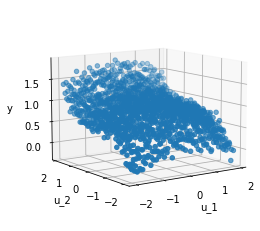

In [77]:
D = pkl.load(open('static_data.pkl','rb'))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.elev = 10 # Höhe der Betrachung
ax.azim = 235 # Neigungswinkel der Betrachtung
ax.scatter(D['u1'],D['u2'],D['y'])

ax.set_xlabel('u_1')
ax.set_ylabel('u_2')
ax.set_zlabel('y')

In [72]:
#u1 = np.arange(-2,2,0.1).reshape((-1,1))
#u2 = np.arange(-2,2,0.1).reshape((-1,1))

#u1, u2 = np.meshgrid(u1, u2)

#y = (1+0.1*u2**3-0.1*u1**2).reshape((-1,1)) 
#y = y + np.random.normal(0,0.1,(len(y),1))
#D = pd.DataFrame(data=np.hstack([u1.reshape((-1,1)),u2.reshape((-1,1)),y]),columns=['u1','u2','y'])
#pkl.dump(D,open('static_data.pkl','wb'))

Als Modellierungsansatz wird ein statisches polynomiales Modell gewählt:
$\hat{y}_{k}=\theta_{1} u_{1,k}^3 + \theta_{2} u_{1,k}^2 + \theta_{3} u_{1,k} + \theta_{4} u_{2,k}^3 + \theta_{5} u_{2,k}^2 + \theta_{6} u_{2,k}$

In [78]:
theta = cs.MX.sym('theta',7,1)

u = cs.MX.sym('u',2,1)
y = theta[0]*u[0]**3 + theta[1]*u[0]**2 + theta[2]*u[0] + theta[3]*u[1]**3 + theta[4]*u[1]**2 + theta[5]*u[1] + theta[6]

f_model = cs.Function('f_model',[u,theta],[y],['u','theta'],['y'])

Das Modell liegt somit als CasADi-Funktion vor, und kann durch Übergabe von numerischen Werten für $\boldsymbol{u}$ und $\boldsymbol{\theta}$ ausgewertet werden.

In [79]:
inputs = {'u':[0.1,0.5],'theta':[1,1,1,1,1,1,1]}
print(f_model(**inputs)['y'])

1.986


In diesem Fall sind die Parameter jedoch nicht bekannt, die unbekannten Parameter werden daher als opti.variable() und damit als zu optimierende Größe definiert

In [80]:
opti = cs.Opti() # 
theta_est = opti.variable(7,1) #

Kostenfunktion

In [81]:
L = 0

for k in range(0,len(D)):
    u_k = D.loc[k][['u1','u2']].values.reshape((2,1))
    y_k = D.loc[k]['y']
    
    y_hat = f_model(u=u_k, theta=theta_est)['y']
    L = L + 0.5*(y_hat - y_k)**2

Anschließend muss die zu optimierende Funktion als CasADi-Funktion definiert werden. Ziel der Optimierung ist $\boldsymbol{\theta}$ so zu wählen, dass die Summe der Abweichungsquadrate $L = \frac{1}{2}\sum\limits_{k}^{N} (\hat{y}_{k}-y_{k})^2$ minimiert wird

In [82]:
opti.minimize(L)

$L$ is nun ein CasADi-Ausdruck, der die Summe des quadratischen Prädiktionsfehlers in Abhängigkeit der Modellparameter $\boldsymbol{\theta}$ beinhaltet. Eine Abhängigkeit von den Eingangs- oder Ausgangssignalen $u_{1}$, $u_{2}$ und $y$ besteht nicht mehr, da diese bereits "eingesetzt" wurden.

In [83]:
opti.solver('ipopt')
sol = opti.solve()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       28

Total number of variables............................:        7
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

In [84]:
theta_opt = sol.value(theta_est)

In [85]:
theta_opt

array([-0.00365128, -0.09995486,  0.00964973,  0.09902041,  0.00566785,
        0.00150326,  0.9918422 ])

In [89]:
y_est = []
for k in range(0,len(D)):
    u_k = D.loc[k][['u1','u2']].values.reshape((2,1))
    y_k = D.loc[k]['y']
    
    y_est.append(f_model(u=u_k, theta=theta_opt)['y'])

Text(0.5, 0, 'y')

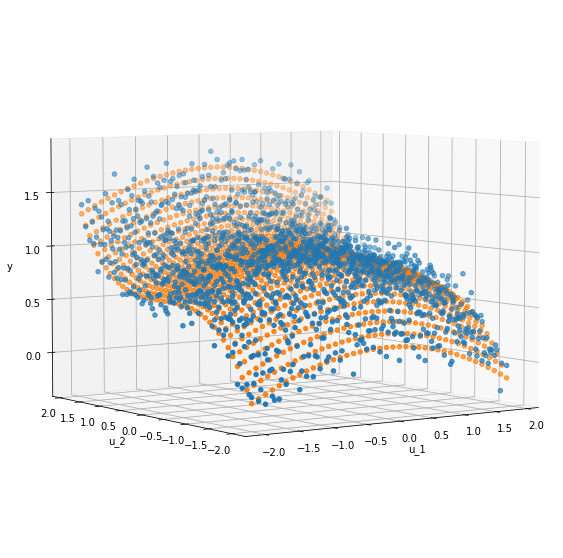

In [96]:
fig = plt.figure()
fig.set_size_inches((30,10))
ax = fig.add_subplot(projection='3d')
ax.elev = 10 # Höhe der Betrachung
ax.azim = 235 # Neigungswinkel der Betrachtung
ax.scatter(D['u1'],D['u2'],D['y'])
ax.scatter(D['u1'],D['u2'],y_est)

ax.set_xlabel('u_1')
ax.set_ylabel('u_2')
ax.set_zlabel('y')

In [94]:
stat_model = {'f_model':f_model,
             'theta_opt':theta_opt}

pkl.dump(stat_model,open('stat_model.pkl','wb') )

In [93]:
f_model

Function(f_model:(u[2],theta[7])->(y) MXFunction)